# AI 기반 척추 스크리닝 — 라벨링 파이프라인 (업데이트)

이 노트북은 다음 기능을 포함합니다.

- ✅ LLM → 레벨별 단일 Bool 라벨 생성 (L1/2~L5/S1)
- ✅ Pydantic 검증: LLM 출력 JSON을 엄격 검증/보정
- ✅ Soft Label(0.0~1.0) 옵션: 불확실성/정도 반영
- ✅ 랜덤 샘플 검수 & 분포 시각화(QC)
- ✅ 프롬프트 업그레이드 헬퍼: 검수 중 새 규칙 → 프롬프트에 자동 반영
- ✅ COCO-like (image-level) 내보내기: 이후 비전 모델 학습을 위한 포맷


In [ ]:
# %%capture
!pip -q install pydantic>=2.5 pydantic-core>=2.14 pandas openpyxl pillow matplotlib
!pip -q install openai
!pip -q install pydantic-ai || true


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.2/297.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.3/295.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.3/426.3 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-"


In [ ]:
from __future__ import annotations
import os, json, re, time
from typing import Dict, Any, List, Optional
import pandas as pd
from pydantic import BaseModel, Field, field_validator, ValidationError, ConfigDict
from PIL import Image
import matplotlib.pyplot as plt

# OpenAI SDK
try:
    from openai import OpenAI
    _openai_available = True
except Exception as e:
    _openai_available = False
    print('OpenAI SDK 불러오기 실패:', e)

MODEL_NAME = 'gpt-4o-mini'  # 필요 시 교체
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
if _openai_available and not OPENAI_API_KEY:
    print('⚠️ 환경변수 OPENAI_API_KEY가 설정되어 있지 않습니다.')
client = OpenAI(api_key=OPENAI_API_KEY) if _openai_available and OPENAI_API_KEY else None

# 경로 기본값 (원하면 변경)
INPUT_EXCEL_PATH = '/content/drive/MyDrive/STEN_cohort_SMC_preprocess.xlsx'  # 보고서 원본
OUT_CSV = '/content/labels_stenosis.csv'           # 기존 Bool 중심 csv
OUT_JSONL = '/content/labels_stenosis.jsonl'       # 원형 jsonl
OUT_COCO = '/content/coco_stenosis.json'           # COCO-like 출력 경로

# (선택) 업로드된 csv를 QC 예시로 바로 확인
FALLBACK_UPLOADED_CSV = 'labels_merged.csv'  # 업로드 파일 있으면 자동 QC

In [ ]:
BASE_SYSTEM_PROMPT = (
    'You are a radiology report labeler for lumbar spine stenosis.\n'
    'Return STRICT JSON only. No code fences, no comments.'
)

BASE_DEV_PROMPT = (
    'Task: For each level (L1/2, L2/3, L3/4, L4/5, L5/S1), decide stenosis presence.\n'
    'Return BOTH:\n'
    '- a single boolean (true/false) \'label\' per level, and\n'
    '- a \'score\' per level in [0.0, 1.0] indicating stenosis severity/likelihood.\n'
    '  * 0.0: definitely no stenosis; 1.0: definite severe stenosis.\n'
    '  * mild ~0.3, moderate ~0.6, severe ~0.9 as a rough guide.\n'
    '  * Ambiguous/uncertain -> around 0.5 and set need_check = true.\n'
    '- Consider synonyms: central canal = canal; subarticular = lateral recess; foraminal = neuroforaminal.\n'
    '- Negative phrases ("no stenosis", "no significant stenosis", "patent", "within normal limits") imply label=false and score near 0.0 (e.g., 0.05).\n'
    '- Any degree (mild/moderate/severe/marked) implies label=true with increasing scores.\n'
    '- If a level is not mentioned at all -> label = null, score = null, need_check = true.\n'
    '- If contradictions exist ("no significant stenosis" AND "mild stenosis" at same level), set need_check = true and explain in reasons.\n'
    '- If any subtypes (central/foraminal/subarticular) disagree, the OR rule applies for the boolean label (true if any subtype positive). For score, take the max.\n'
    '- Korean/English mixed reports are allowed.\n\n'
    'Output STRICT JSON schema:\n'
    '{\n'
    '  "patient_id": "<string>",\n'
    '  "levels": {\n'
    '    "L1_2": {"label": true|false|null, "score": 0.0|0.1|...|1.0|null},\n'
    '    "L2_3": {"label": true|false|null, "score": 0.0|...|1.0|null},\n'
    '    "L3_4": {"label": true|false|null, "score": 0.0|...|1.0|null},\n'
    '    "L4_5": {"label": true|false|null, "score": 0.0|...|1.0|null},\n'
    '    "L5_S1": {"label": true|false|null, "score": 0.0|...|1.0|null}\n'
    '  },\n'
    '  "need_check": true|false,\n'
    '  "reasons": ["<short explanation>", "..."]\n'
    '}\n'
)

def build_messages(report_text: str, patient_id: str, system_prompt: str = BASE_SYSTEM_PROMPT, dev_prompt: str = BASE_DEV_PROMPT):
    user_prompt = f'Report:\n<<<\n{report_text}\n>>>\nPatient ID: {patient_id}\nReturn STRICT JSON only.'
    return [
        {"role": "system", "content": system_prompt},
        {"role": "developer", "content": dev_prompt},
        {"role": "user", "content": user_prompt},
    ]

In [ ]:
LEVEL_KEYS = ['L1_2','L2_3','L3_4','L4_5','L5_S1']

class LevelValue(BaseModel):
    label: Optional[bool] = Field(default=None)
    score: Optional[float] = Field(default=None)

    @field_validator('score')
    def check_score(cls, v):
        if v is None:
            return v
        if not (0.0 <= float(v) <= 1.0):
            raise ValueError('score must be in [0.0, 1.0] or null')
        return float(v)

class LLMResult(BaseModel):
    model_config = ConfigDict(extra='ignore')
    patient_id: str
    levels: Dict[str, LevelValue]
    need_check: bool
    reasons: List[str]

    @field_validator('levels')
    @classmethod
    def ensure_levels(cls, v: Dict[str, Any]):
        for k in LEVEL_KEYS:
            if k not in v:
                v[k] = LevelValue(label=None, score=None)
        return v

def validate_and_fix(parsed: Dict[str, Any]) -> LLMResult:
    try:
        obj = LLMResult.model_validate(parsed)
        for k in LEVEL_KEYS:
            lv = obj.levels[k]
            if not isinstance(lv.label, (bool, type(None))):
                s = str(lv.label).strip().lower()
                if s in {'true','1','yes','y','있음'}:
                    lv.label = True
                elif s in {'false','0','no','n','없음'}:
                    lv.label = False
                else:
                    lv.label = None
                    obj.need_check = True
                    obj.reasons.append(f'{k}: non-boolean label coerced to null')
        obj.reasons = sorted(set([r for r in obj.reasons if r and isinstance(r, str)]))
        return obj
    except ValidationError as e:
        reasons = [f"ValidationError: {err['msg']}" for err in e.errors()]
        fallback = {
            'patient_id': str(parsed.get('patient_id','')).strip(),
            'levels': {k: {'label': None, 'score': None} for k in LEVEL_KEYS},
            'need_check': True,
            'reasons': reasons + ['Fell back due to validation error'],
        }
        return LLMResult.model_validate(fallback)

In [ ]:
FENCE_RE = re.compile(r'^```(?:json)?\s*|\s*```$', re.IGNORECASE | re.DOTALL)
def strip_fences(s: str) -> str:
    return FENCE_RE.sub('', s).strip()

LEVEL_PATTERNS = {
    'L1_2': r'(L1[\-/]?\s*2|L1\s*[-–/]\s*2|L1/2)',
    'L2_3': r'(L2[\-/]?\s*3|L2\s*[-–/]\s*3|L2/3)',
    'L3_4': r'(L3[\-/]?\s*4|L3\s*[-–/]\s*4|L3/4)',
    'L4_5': r'(L4[\-/]?\s*5|L4\s*[-–/]\s*5|L4/5)',
    'L5_S1': r'(L5[\-/]?\s*S1|L5\s*[-–/]\s*S1|L5/S1)',
}
POS = r'(stenosis|narrowing|협착)'
NEG = r'(no (significant )?stenosis|without stenosis|no abnormal|patent|정상|협착\s*없)'

def regex_backup(report_text: str, patient_id: str) -> LLMResult:
    txt = ' '.join(report_text.split())
    levels = {}
    reasons = ['LLM failed; regex backup used']
    need_check = True
    for k, pat in LEVEL_PATTERNS.items():
        m = re.search(pat, txt, re.IGNORECASE)
        if not m:
            levels[k] = {'label': None, 'score': None}
            continue
        start = max(0, m.start()-40); end = min(len(txt), m.end()+40)
        window = txt[start:end].lower()
        if re.search(POS, window):
            if re.search(NEG, window):
                levels[k] = {'label': None, 'score': 0.5}
                reasons.append(f'{k}: positive and negative cues conflict')
            else:
                levels[k] = {'label': True, 'score': 0.6}
        elif re.search(NEG, window):
            levels[k] = {'label': False, 'score': 0.05}
        else:
            levels[k] = {'label': None, 'score': None}
    raw = {'patient_id': str(patient_id), 'levels': levels, 'need_check': need_check, 'reasons': reasons}
    return validate_and_fix(raw)

In [ ]:
def call_llm(report_text: str, patient_id: str, system_prompt: str = BASE_SYSTEM_PROMPT, dev_prompt: str = BASE_DEV_PROMPT,
             max_retries: int = 3, sleep_base: float = 2.0) -> LLMResult:
    if client is None:
        return regex_backup(report_text, patient_id)
    msgs = build_messages(report_text, patient_id, system_prompt, dev_prompt)
    last_err = None
    for i in range(max_retries):
        try:
            resp = client.chat.completions.create(
                model=MODEL_NAME,
                messages=msgs,
                temperature=0,
            )
            raw = strip_fences(resp.choices[0].message.content.strip())
            parsed = json.loads(raw)
            return validate_and_fix(parsed)
        except Exception as e:
            last_err = e
            time.sleep(sleep_base**i)
    return regex_backup(report_text, patient_id)

In [ ]:
def run_labeling_excel(
    excel_path: str,
    id_col: str = '환자번호',
    report_col: str = '검사결과',
    out_csv: str = OUT_CSV,
    out_jsonl: str = OUT_JSONL,
    sample_n: Optional[int] = None,
    system_prompt: str = BASE_SYSTEM_PROMPT,
    dev_prompt: str = BASE_DEV_PROMPT,
):
    df = pd.read_excel(excel_path)
    if sample_n:
        df = df.sample(n=sample_n, random_state=42).copy()

    rows = []
    jsonl_items = []
    for _, row in df.iterrows():
        pid = str(row[id_col])
        rpt = str(row[report_col])
        result = call_llm(rpt, pid, system_prompt=system_prompt, dev_prompt=dev_prompt)

        flat = {
            'patient_id': result.patient_id,
            'L1_2': result.levels['L1_2'].label,
            'L2_3': result.levels['L2_3'].label,
            'L3_4': result.levels['L3_4'].label,
            'L4_5': result.levels['L4_5'].label,
            'L5_S1': result.levels['L5_S1'].label,
            'L1_2_score': result.levels['L1_2'].score,
            'L2_3_score': result.levels['L2_3'].score,
            'L3_4_score': result.levels['L3_4'].score,
            'L4_5_score': result.levels['L4_5'].score,
            'L5_S1_score': result.levels['L5_S1'].score,
            'need_check': result.need_check,
            'reasons': '; '.join(result.reasons),
        }
        rows.append(flat)
        jsonl_items.append(result.model_dump())

    out_df = pd.DataFrame(rows)
    out_df.to_csv(out_csv, index=False, encoding='utf-8-sig')
    with open(out_jsonl, 'w', encoding='utf-8') as f:
        for item in jsonl_items:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    return out_df

# 예시 실행 (처음엔 샘플 20개)
# out_df = run_labeling_excel(INPUT_EXCEL_PATH, sample_n=20)
# out_df.head()

## QC: 랜덤 샘플 검수 + 분포 확인

== Detected columns ==
L1_2   -> label: 'L1/2' | score: None
L2_3   -> label: 'L2/3' | score: None
L3_4   -> label: 'L3/4' | score: None
L4_5   -> label: 'L4/5' | score: None
L5_S1  -> label: 'L5/S1' | score: None
[L1_2] true=0.00% false=100.00% null=0.00%
[L2_3] true=3.33% false=96.67% null=0.00%
[L3_4] true=20.00% false=80.00% null=0.00%
[L4_5] true=30.00% false=70.00% null=0.00%
[L5_S1] true=16.67% false=83.33% null=0.00%
[QC] need_check ratio in sample: 6.67%


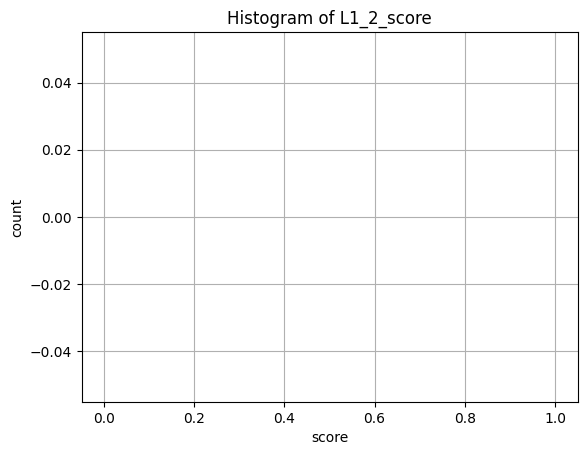

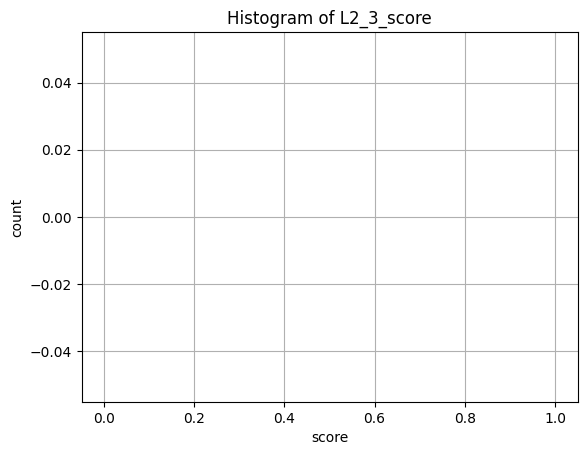

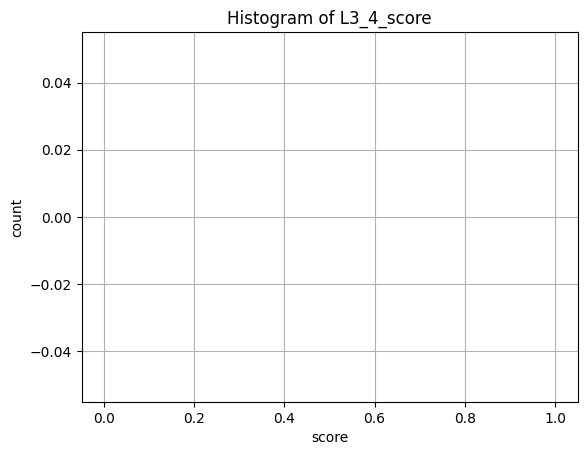

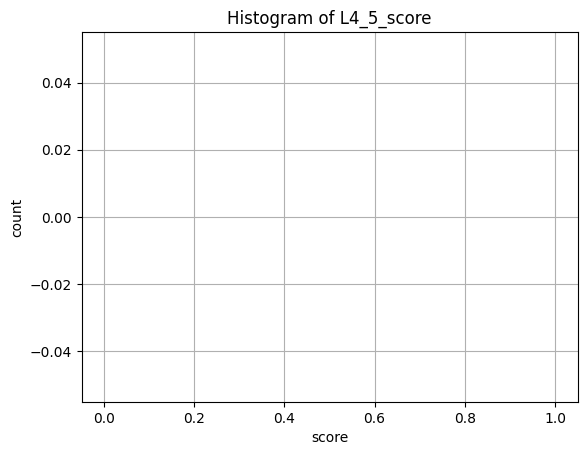

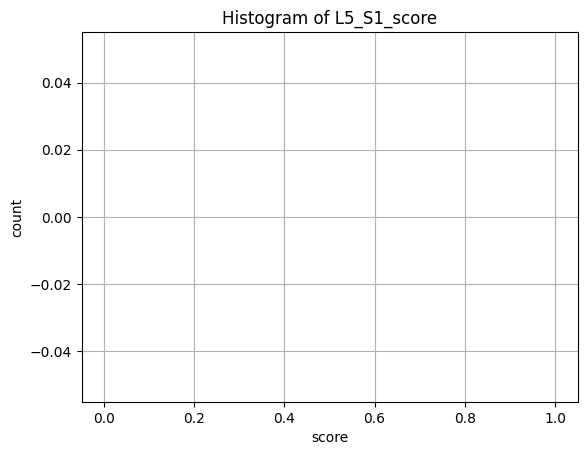

In [ ]:
# ✅ Robust QC: 컬럼 자동 인식/정규화 + 분포/히스토그램
import re, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

LEVELS = ["L1_2","L2_3","L3_4","L4_5","L5_S1"]

def _norm_col(s: str) -> str:
    # 기본 정규화: 공백 제거, 소문자, 슬래시/대시→언더스코어, s1 → s1 유지
    s0 = str(s).strip()
    s1 = re.sub(r"\s+", "", s0)
    s2 = s1.replace("/", "_").replace("-", "_")
    return s2

def _match_label_col(col: str, target: str) -> bool:
    # target은 'L1_2' 같은 표준형
    # 매칭: l1_2, L1/2, L1-2, 'L1_2 여부', 'l1_2_label' 등 폭넓게 허용
    t = target.upper()
    c = _norm_col(col).upper()
    if c == t:
        return True
    # 정확 레벨 패턴
    lv_pat = {
        "L1_2": r"L\s*1\s*[_\-\/ ]\s*2\b",
        "L2_3": r"L\s*2\s*[_\-\/ ]\s*3\b",
        "L3_4": r"L\s*3\s*[_\-\/ ]\s*4\b",
        "L4_5": r"L\s*4\s*[_\-\/ ]\s*5\b",
        "L5_S1": r"L\s*5\s*[_\-\/ ]\s*S\s*1\b",
    }[target]
    # 점수 컬럼이 아닌 라벨 컬럼 후보 (score 단어가 들어가면 제외)
    return (re.search(lv_pat, c, re.IGNORECASE) is not None) and ("SCORE" not in c)

def _match_score_col(col: str, target: str) -> bool:
    t = target.upper()
    c = _norm_col(col).upper()
    if c == f"{t}_SCORE":
        return True
    # L1/2_score, L1-2Score, l1_2prob 등 폭넓게 허용
    lv_pat = {
        "L1_2": r"L\s*1\s*[_\-\/ ]\s*2",
        "L2_3": r"L\s*2\s*[_\-\/ ]\s*3",
        "L3_4": r"L\s*3\s*[_\-\/ ]\s*4",
        "L4_5": r"L\s*4\s*[_\-\/ ]\s*5",
        "L5_S1": r"L\s*5\s*[_\-\/ ]\s*S\s*1",
    }[target]
    return (re.search(lv_pat, c, re.IGNORECASE) is not None) and ("SCORE" in c or "PROB" in c or "LOGIT" in c)

def _coerce_bool(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip().lower()
    if s in {"true","t","1","yes","y","있음"}: return True
    if s in {"false","f","0","no","n","없음"}: return False
    # 숫자: 0/1/그 외 확률값 -> 임계 0.5로 대략 변환 (점검용)
    try:
        v = float(s)
        if v == 0.0: return False
        if v == 1.0: return True
        if 0.0 <= v <= 1.0: return True if v >= 0.5 else False
    except:
        pass
    return pd.NA

def qc_random_review(csv_path: str, n: int = 30, seed: int = 42):
    df = pd.read_csv(csv_path)
    if len(df) == 0:
        print("빈 CSV입니다.")
        return df

    # ----- 컬럼 매핑 탐색 -----
    label_col_map = {}
    score_col_map = {}
    for target in LEVELS:
        lab = next((c for c in df.columns if _match_label_col(c, target)), None)
        sc  = next((c for c in df.columns if _match_score_col(c, target)), None)
        label_col_map[target] = lab
        score_col_map[target] = sc

    # 매핑 결과 안내
    print("== Detected columns ==")
    for lv in LEVELS:
        print(f"{lv:6s} -> label: {label_col_map[lv]!r} | score: {score_col_map[lv]!r}")

    # 최소 하나라도 못 찾으면 컬럼 목록 보여주고 종료(사용자 CSV 구조 확인)
    missing = [lv for lv,c in label_col_map.items() if c is None]
    if len(missing) == len(LEVELS):
        print("\n라벨 컬럼을 전혀 찾지 못했습니다. df.columns 를 확인하세요:")
        print(list(df.columns))
        return df

    # 라벨/점수 컬럼 표준화 뷰 생성
    work = df.copy()
    for lv in LEVELS:
        lab = label_col_map[lv]
        sc  = score_col_map[lv]
        if lab and lab not in work.columns:  # 방어적
            continue
        if lab:
            work[lv] = work[lab].apply(_coerce_bool)
        else:
            work[lv] = pd.NA
        if sc and sc in work.columns:
            # 점수는 0~1로 클리핑
            svals = pd.to_numeric(work[sc], errors="coerce")
            work[f"{lv}_score"] = svals.clip(lower=0.0, upper=1.0)
        else:
            work[f"{lv}_score"] = pd.NA

    # need_check가 없을 수도 있으니 안전 처리
    if "need_check" not in work.columns:
        work["need_check"] = pd.NA

    # ----- 샘플링 -----
    sample = work.sample(n=min(n, len(work)), random_state=seed)

    # ----- 통계 -----
    for lv in LEVELS:
        vc = sample[lv].value_counts(dropna=False, normalize=True)
        true_ratio  = vc.get(True, 0.0)
        false_ratio = vc.get(False, 0.0)
        null_ratio  = sample[lv].isna().mean()
        print(f"[{lv}] true={true_ratio:.2%} false={false_ratio:.2%} null={null_ratio:.2%}")

    if work["need_check"].notna().any():
        need_ratio = sample["need_check"].mean(skipna=True)
        print(f"[QC] need_check ratio in sample: {0.0 if pd.isna(need_ratio) else need_ratio:.2%}")
    else:
        print("[QC] need_check 컬럼이 없어 생략합니다.")

    # ----- 히스토그램 -----
    for lv in LEVELS:
        col = f"{lv}_score"
        if col in sample.columns:
            plt.figure()
            sample[col].dropna().astype(float).hist(bins=20)
            plt.title(f"Histogram of {col}")
            plt.xlabel("score"); plt.ylabel("count")
            plt.show()

    # 표시
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("QC Random Sample (normalized view)", sample[
            ["patient_id"] + [lv for lv in LEVELS] + [f"{lv}_score" for lv in LEVELS] + (["need_check"] if "need_check" in sample.columns else [])
        ])
    except Exception:
        pass
    return sample

# ---- 실행: 기존 결과 CSV 또는 업로드된 CSV ----
qc_path = OUT_CSV if Path(OUT_CSV).exists() else (FALLBACK_UPLOADED_CSV if Path(FALLBACK_UPLOADED_CSV).exists() else None)
if qc_path:
    _qc_sample = qc_random_review(qc_path, n=30)
else:
    print("QC 대상 CSV가 없습니다. 먼저 라벨링을 실행하거나 CSV 경로를 설정하세요.")


## 프롬프트 업그레이드 헬퍼 (need_check 사유 기반 규칙 주입)

In [ ]:
def mine_rules_from_reasons(csv_path: str, top_k: int = 10):
    df = pd.read_csv(csv_path)
    if 'reasons' not in df.columns:
        print('reasons 컬럼이 없습니다.')
        return []
    from collections import Counter
    all_reasons = []
    for r in df['reasons'].dropna():
        parts = [p.strip() for p in str(r).split(';') if p.strip()]
        all_reasons.extend(parts)
    freq = Counter(all_reasons)
    common = freq.most_common(top_k)
    print('[Top reasons]')
    for k, v in common:
        print(f'  {v:4d}  {k}')
    rules = []
    for k, v in common:
        if 'null/ambiguous' in k or 'missing' in k:
            rules.append('- If a level mention is absent or ambiguous, explicitly output label=null and score=null (not false).')
        if 'conflict' in k:
            rules.append('- When conflicting phrases appear, set need_check=true and reflect uncertainty with score≈0.5.')
    rules = sorted(set(rules))
    return rules

def update_dev_prompt_with_rules(dev_prompt: str, new_rules: List[str]) -> str:
    if not new_rules:
        return dev_prompt
    addendum = '\nADDITIONAL RULES:\n' + '\n'.join(new_rules) + '\n'
    if addendum in dev_prompt:
        return dev_prompt
    return dev_prompt + addendum

# 사용 예시
# new_rules = mine_rules_from_reasons(OUT_CSV, top_k=10)
# BASE_DEV_PROMPT = update_dev_prompt_with_rules(BASE_DEV_PROMPT, new_rules)
# print(BASE_DEV_PROMPT)

## COCO-like (image-level) 내보내기

In [ ]:
from datetime import datetime

def load_image_size(path: str):
    try:
        with Image.open(path) as im:
            return im.size  # (w,h)
    except Exception:
        return (0,0)

def export_coco_like(mapping_csv: str, labels_csv: str = OUT_CSV, out_path: str = OUT_COCO,
                     categories: Optional[List[str]] = None):
    if categories is None:
        categories = LEVEL_KEYS
    df_map = pd.read_csv(mapping_csv)
    df_lab = pd.read_csv(labels_csv)
    if 'patient_id' not in df_lab.columns:
        raise ValueError("labels_csv must have 'patient_id' column")
    lab_idx = df_lab.set_index('patient_id')

    images = []
    annotations = []
    cats = [{'id': i+1, 'name': cat, 'supercategory': 'stenosis'} for i,cat in enumerate(categories)]
    image_id = 1
    ann_id = 1

    for _, r in df_map.iterrows():
        pid = str(r['patient_id'])
        img_path = str(r['image_path'])
        w,h = load_image_size(img_path)
        images.append({'id': image_id, 'file_name': img_path, 'width': w, 'height': h, 'patient_id': pid})

        if pid in lab_idx.index:
            labrow = lab_idx.loc[pid]
            for i, lvl in enumerate(LEVEL_KEYS):
                label = labrow.get(lvl)
                score = labrow.get(f'{lvl}_score')
                bw = w if w>0 else 1
                bh = h if h>0 else 1
                bbox = [0,0,bw,bh]
                annotations.append({
                    'id': ann_id,
                    'image_id': image_id,
                    'category_id': i+1,
                    'bbox': bbox,
                    'area': bw*bh,
                    'iscrowd': 0,
                    'attributes': {
                        'label': None if pd.isna(label) else bool(label),
                        'score': None if pd.isna(score) else float(score)
                    }
                })
                ann_id += 1
        image_id += 1

    coco = {
        'info': {
            'year': datetime.now().year,
            'version': '1.0',
            'description': 'COCO-like classification for lumbar stenosis',
            'date_created': datetime.now().isoformat()
        },
        'licenses': [],
        'images': images,
        'annotations': annotations,
        'categories': cats
    }
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump(coco, f, ensure_ascii=False, indent=2)
    print(f'COCO-like saved -> {out_path} (images={len(images)}, annotations={len(annotations)})')

# 사용 예시 (mapping csv 필요)
# mapping.csv 스키마:
# patient_id,image_path
# 001,/content/xray/001.png
# export_coco_like('/content/mapping.csv', labels_csv=OUT_CSV, out_path=OUT_COCO)

Uploaded CSV Detected -> running QC demo on: labels_merged.csv
== Detected columns ==
L1_2   -> label: 'L1/2' | score: None
L2_3   -> label: 'L2/3' | score: None
L3_4   -> label: 'L3/4' | score: None
L4_5   -> label: 'L4/5' | score: None
L5_S1  -> label: 'L5/S1' | score: None
[L1_2] true=0.00% false=100.00% null=0.00%
[L2_3] true=0.00% false=100.00% null=0.00%
[L3_4] true=20.00% false=80.00% null=0.00%
[L4_5] true=30.00% false=70.00% null=0.00%
[L5_S1] true=15.00% false=85.00% null=0.00%
[QC] need_check ratio in sample: 10.00%


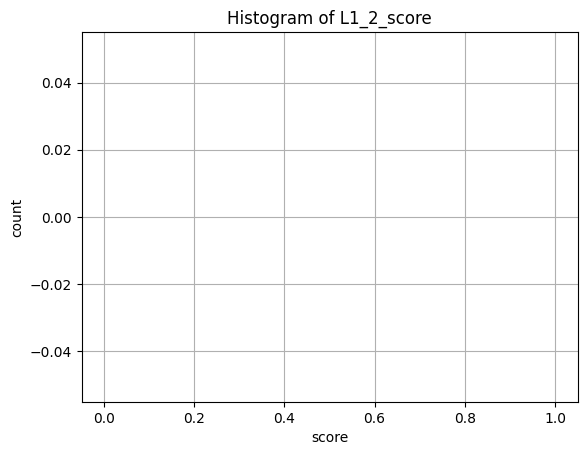

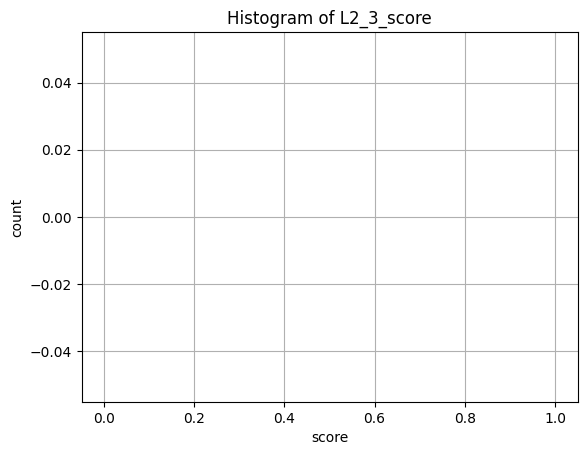

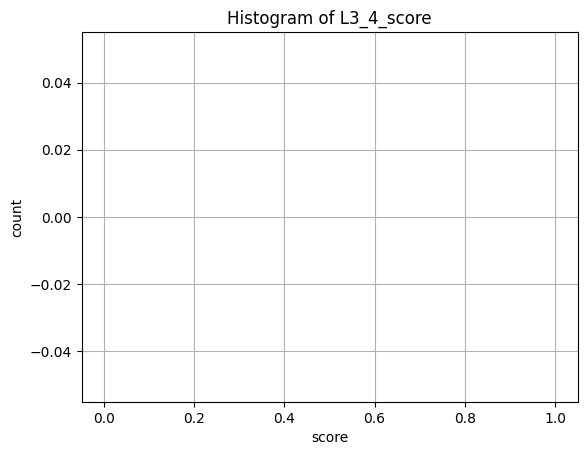

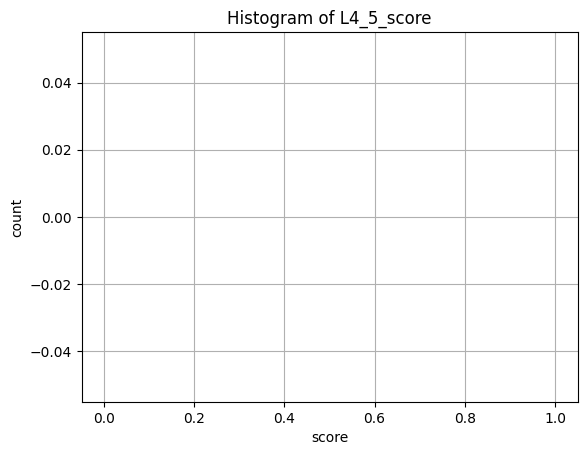

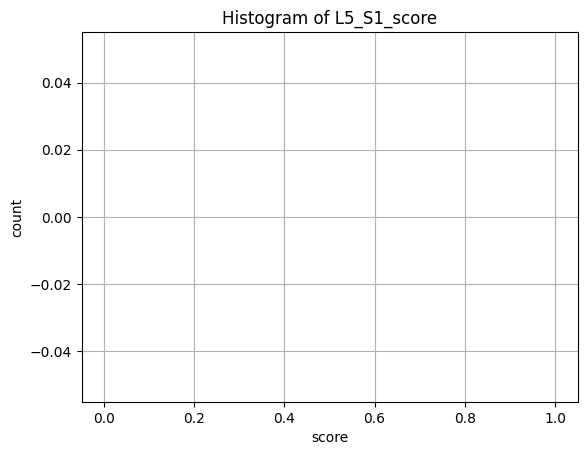

In [ ]:
from pathlib import Path as P
if P(FALLBACK_UPLOADED_CSV).exists():
    print('Uploaded CSV Detected -> running QC demo on:', FALLBACK_UPLOADED_CSV)
    _ = qc_random_review(FALLBACK_UPLOADED_CSV, n=20)
else:
    print('Tip) run_labeling_excel()로 라벨 생성 후 qc_random_review(OUT_CSV) 호출하세요.')

Mounted at /content/drive
[INFO] 탐지된 컬럼 → id_col='환자번호', report_col='검사결과'
[INFO] 엑셀 컬럼 미리보기: ['환자번호', '검사결과', 'L1/2', 'L2/3', 'L3/4', 'L4/5', 'L5/S1']

[STEP] 스모크 테스트(20건) 실행 중…
[OK] 스모크 완료. 미리보기:


,patient_id,L1_2,L2_3,L3_4,L4_5,L5_S1,L1_2_score,L2_3_score,L3_4_score,L4_5_score,L5_S1_score,need_check,reasons
0,36158785,NaN,NaN,True,False,False,NaN,NaN,0.6,0.05,0.05,False,NaN
1,28567896,NaN,NaN,NaN,True,True,NaN,NaN,NaN,0.60,0.90,False,NaN
2,48296877,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,0.60,NaN,False,NaN
3,49621122,NaN,NaN,NaN,True,True,NaN,NaN,NaN,0.60,0.50,False,NaN
4,2588882,NaN,True,True,True,NaN,NaN,0.3,0.3,0.90,NaN,False,NaN



[STEP] 전체 재라벨링 실행 중…
[DONE] 생성 완료:
- CSV:  /content/labels_stenosis.csv
- JSONL:/content/labels_stenosis.jsonl

[STEP] QC 실행 중…
== Detected columns ==
L1_2   -> label: 'L1_2' | score: 'L1_2_score'
L2_3   -> label: 'L2_3' | score: 'L2_3_score'
L3_4   -> label: 'L3_4' | score: 'L3_4_score'
L4_5   -> label: 'L4_5' | score: 'L4_5_score'
L5_S1  -> label: 'L5_S1' | score: 'L5_S1_score'
[L1_2] true=12.46% false=10.43% null=77.11%
[L2_3] true=29.61% false=13.03% null=57.36%
[L3_4] true=44.19% false=12.22% null=43.59%
[L4_5] true=54.38% false=16.32% null=29.30%
[L5_S1] true=42.71% false=12.60% null=44.69%
[QC] need_check ratio in sample: 18.87%


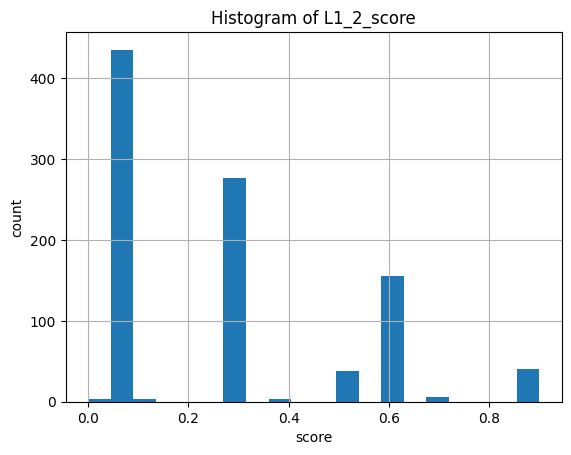

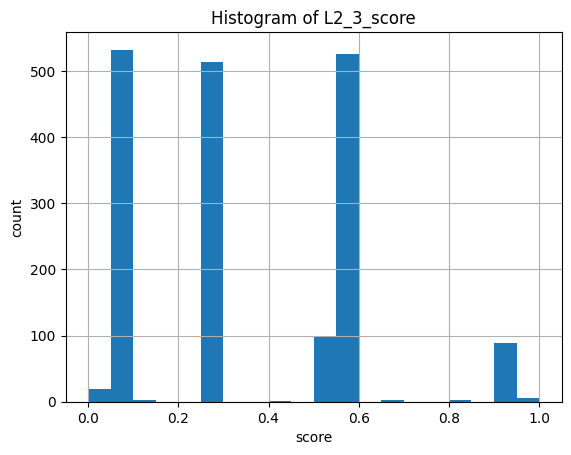

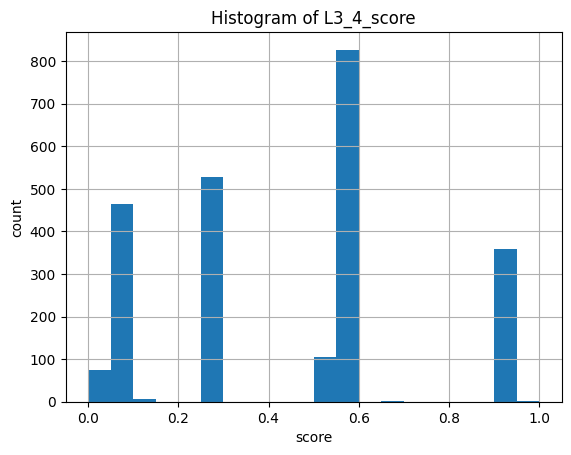

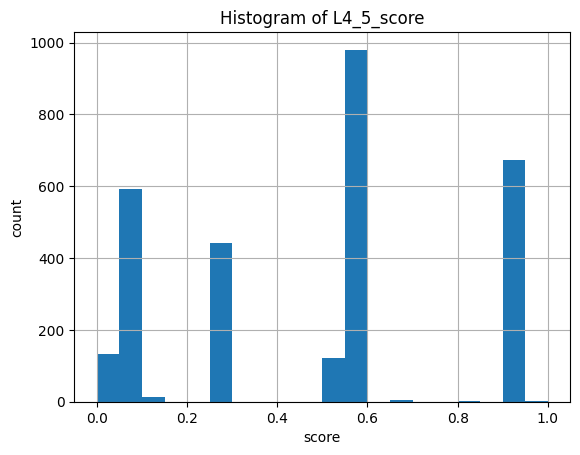

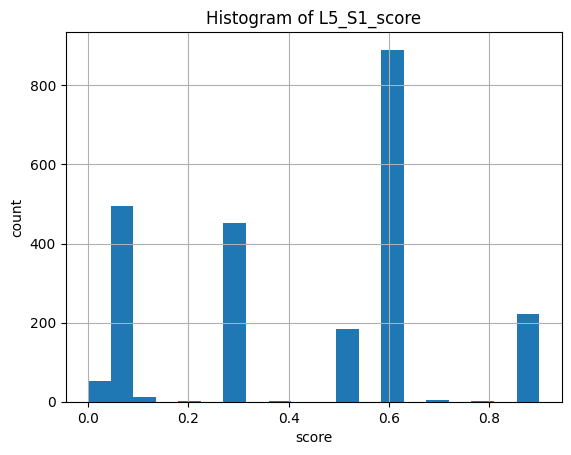


[STEP] 프롬프트 업그레이드 규칙 후보:
[Top reasons]
    71  No mention of stenosis at any level.
    27  No mention of lumbar spine levels in the report.
    16  No mention of lumbar spine stenosis in the report.
    12  No mention of stenosis at L1/2, L2/3, L3/4, L4/5 levels
    10  No mention of stenosis at L1/2, L2/3, L3/4, and L5/S1 levels
    10  No specific mention of stenosis at any level.
     7  No mention of lumbar spine stenosis at any level.
     7  No specific findings regarding stenosis were mentioned in the report.
     5  No specific mention of stenosis at L1/2, L2/3, L3/4, and L4/5 levels
     5  No mention of stenosis at L1/2, L2/3, L3/4, and L5/S1 levels.

[GUIDE] Soft label(score)까지 CSV에 들어갔습니다. Vision 학습에서 soft-label로 활용 가능해요.
[GUIDE] COCO-like로 내보내려면 mapping.csv 준비 후 아래 예시를 실행하세요:
export_coco_like('/content/mapping.csv', labels_csv=OUT_CSV, out_path='/content/coco_stenosis.json')


In [ ]:
# === A단계: MRI 판독문 엑셀 → 새 라벨/스코어 CSV & JSONL 생성 ===
# 준비물: (1) OPENAI_API_KEY  (2) 판독문 엑셀파일 경로 + 컬럼명(환자번호/검사결과)
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd
from pathlib import Path

# 1) API 키 넣기 — 반드시 수정
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or "sk-"

# 2) 입력 엑셀 경로 — 필요시 수정
INPUT_EXCEL_PATH = "/content/drive/MyDrive/STEN_cohort_SMC_preprocess.xlsx"  # 예시 경로

# 3) 출력 경로(원하면 바꾸기)
OUT_CSV   = "/content/labels_stenosis.csv"
OUT_JSONL = "/content/labels_stenosis.jsonl"

# 4) 컬럼명 자동탐지 (못 찾으면 기본값 사용)
#    candidates를 바꿔서 넓혀도 됩니다.
ID_CANDIDATES     = ["환자번호","patient_id","Patient_ID","ID","pid"]
REPORT_CANDIDATES = ["검사결과","report","소견","판독문","impression","finding","findings","결과"]

def _guess_cols(xlsx_path):
    df_head = pd.read_excel(xlsx_path, nrows=1)
    cols = list(df_head.columns)
    def pick(cands):
        for c in cands:
            if c in cols:
                return c
        # 유사 키워드 매칭(대충)
        lower = {c:str(c).lower() for c in cols}
        for c in cols:
            l = lower[c]
            if any(k in l for k in ["환자","patient","id"]):
                return c
        for c in cols:
            l = lower[c]
            if any(k in l for k in ["검사","소견","판독","report","impress","finding"]):
                return c
        return None

    return pick(ID_CANDIDATES), pick(REPORT_CANDIDATES), cols

id_col, report_col, preview_cols = _guess_cols(INPUT_EXCEL_PATH)
print(f"[INFO] 탐지된 컬럼 → id_col={id_col!r}, report_col={report_col!r}")
print("[INFO] 엑셀 컬럼 미리보기:", preview_cols)

if id_col is None or report_col is None:
    raise ValueError("엑셀에서 환자 식별자/판독문 컬럼을 찾지 못했습니다. 셀 상단의 ID_CANDIDATES/REPORT_CANDIDATES를 수정하세요.")

# 5) 스모크 테스트(샘플 20건) → OK면 전체 실행
print("\n[STEP] 스모크 테스트(20건) 실행 중…")
_ = run_labeling_excel(
    excel_path=INPUT_EXCEL_PATH,
    id_col=id_col,
    report_col=report_col,
    out_csv=OUT_CSV,
    out_jsonl=OUT_JSONL,
    sample_n=20,
)
print("[OK] 스모크 완료. 미리보기:")
display(pd.read_csv(OUT_CSV).head())

# 6) 전체 재라벨링
print("\n[STEP] 전체 재라벨링 실행 중…")
_ = run_labeling_excel(
    excel_path=INPUT_EXCEL_PATH,
    id_col=id_col,
    report_col=report_col,
    out_csv=OUT_CSV,
    out_jsonl=OUT_JSONL,
    sample_n=None,   # 전체
)
print(f"[DONE] 생성 완료:\n- CSV:  {OUT_CSV}\n- JSONL:{OUT_JSONL}")

# 7) QC(히스토그램 포함) — 새 CSV로 확인
print("\n[STEP] QC 실행 중…")
_ = qc_random_review(OUT_CSV, n=10_000)

# 8) (선택) 프롬프트 업그레이드 규칙 미닝
print("\n[STEP] 프롬프트 업그레이드 규칙 후보:")
try:
    new_rules = mine_rules_from_reasons(OUT_CSV, top_k=10)
    for r in new_rules:
        print("  ", r)
except Exception as e:
    print("  (reasons 컬럼이 없거나 비어 있습니다) ->", e)

print("\n[GUIDE] Soft label(score)까지 CSV에 들어갔습니다. Vision 학습에서 soft-label로 활용 가능해요.")
print("[GUIDE] COCO-like로 내보내려면 mapping.csv 준비 후 아래 예시를 실행하세요:\n"
      "export_coco_like('/content/mapping.csv', labels_csv=OUT_CSV, out_path='/content/coco_stenosis.json')")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# === 1) 라벨 매칭 패치: labels_stenosis.csv ↔ 이미지 파일 매칭 + soft score 준비 ===
import re, os, numpy as np, pandas as pd
from pathlib import Path

# 경로/기본값 (이미 위 셀에서 정의됐다면 그대로 사용됨)
CSV_PATH  = globals().get("CSV_PATH",  "/content/labels_stenosis.csv")
DATA_ROOT = globals().get("DATA_ROOT", "/content/drive/MyDrive/lumbar_spinal_dataset")
TRAIN_DIR = globals().get("TRAIN_DIR", f"{DATA_ROOT}/training")
TEST_DIR  = globals().get("TEST_DIR",  f"{DATA_ROOT}/testing")
CLASS_NAMES = globals().get("CLASS_NAMES", ["Herniated Disc", "Thecal Sac", "No Stenosis"])
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
MAPPING_CSV = globals().get("MAPPING_CSV", None)  # 입력 필요 시 "patient_id,image_path" 형식

# 0) CSV 로드
df_lab = pd.read_csv(CSV_PATH)

# 1) soft score 계산(각 레벨 score 중 최대)
score_cols = [c for c in df_lab.columns if c.endswith("_score")]
if not score_cols:
    raise ValueError("CSV에 *_score 컬럼이 없습니다. 재라벨링 단계에서 score가 생성되었는지 확인하세요.")
df_lab[score_cols] = df_lab[score_cols].apply(pd.to_numeric, errors="coerce")
df_lab["soft_stenosis_score"] = df_lab[score_cols].max(axis=1, skipna=True)

# (옵션) any stenosis boolean
bool_cols = [c for c in ["L1_2","L2_3","L3_4","L4_5","L5_S1"] if c in df_lab.columns]
df_lab["any_stenosis_bool"] = df_lab[bool_cols].any(axis=1) if bool_cols else np.nan

# 2) patient_id 정규화 키 (숫자만 추출 + 선행 0 제거)
def normalize_pid(x):
    s = "" if pd.isna(x) else str(x)
    digits = "".join(ch for ch in s if ch.isdigit())
    if digits == "": return None
    try: return str(int(digits))
    except: return digits

if "patient_id" not in df_lab.columns:
    raise ValueError("labels CSV에 'patient_id' 컬럼이 없습니다.")
df_lab["patient_id"] = df_lab["patient_id"].astype(str)
df_lab["pid_norm"] = df_lab["patient_id"].apply(normalize_pid)

# 3) 이미지 목록 만들기
def build_df_from_folder(root_dir, class_names):
    rows = []
    r = Path(root_dir)
    for cls in class_names:
        d = r / cls
        if not d.exists():
            print(f"[WARN] Missing class folder: {d}")
            continue
        for p in d.rglob("*"):
            if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}:
                rows.append({"image_path": str(p), "class_name": cls})
    return pd.DataFrame(rows)

df_train = build_df_from_folder(TRAIN_DIR, CLASS_NAMES)
df_test  = build_df_from_folder(TEST_DIR,  CLASS_NAMES)

# 4) 파일명에서 환자번호 추출 → 동일 규칙으로 정규화
ID_PATTERNS = [
    re.compile(r"(?i)(?:^|[_\-/])(?:pid|patient|pt)?[_\-]?(\d{3,})"),
    re.compile(r"(?i)^(\d{3,})"),
]
def extract_pid_from_name(name: str):
    base = Path(name).stem
    for pat in ID_PATTERNS:
        m = pat.search(base)
        if m:
            try: return str(int(m.group(1)))  # 선행 0 제거
            except: return m.group(1)
    return None

for _df in (df_train, df_test):
    _df["patient_id"] = _df["image_path"].apply(lambda s: extract_pid_from_name(Path(s).name))
    _df["pid_norm"]   = _df["patient_id"].apply(normalize_pid)

# 5) (선택) mapping.csv로 보강 매칭 (파일명으로 못 찾는 경우)
if MAPPING_CSV:
    df_map = pd.read_csv(MAPPING_CSV)
    df_map["patient_id"] = df_map["patient_id"].astype(str)
    df_map["pid_norm"] = df_map["patient_id"].apply(normalize_pid)
    df_map["_fname"] = df_map["image_path"].apply(lambda s: Path(str(s)).name)

    for name, _df in [("train", df_train), ("test", df_test)]:
        _df["_fname"] = _df["image_path"].apply(lambda s: Path(str(s)).name)
        _df = _df.merge(df_map[["_fname","pid_norm"]], on="_fname", how="left", suffixes=("","_map"))
        _df["pid_norm"] = _df["pid_norm"].fillna(_df["pid_norm_map"])
        _df.drop(columns=["_fname","pid_norm_map"], inplace=True)
        if name == "train": df_train = _df
        else: df_test = _df

# 6) 라벨 병합 (pid_norm 키로)
def merge_labels(df_images, df_labels):
    return df_images.merge(
        df_labels[["pid_norm","soft_stenosis_score","any_stenosis_bool"]],
        on="pid_norm", how="left"
    )

df_train = merge_labels(df_train, df_lab)
df_test  = merge_labels(df_test,  df_lab)

# 7) 매칭율 보고
def match_report(name, df_):
    total = len(df_)
    hit = df_["soft_stenosis_score"].notna().sum()
    print(f"[{name}] matched soft score: {hit}/{total} ({(hit/total if total else 0):.1%})")
    miss = df_.loc[df_["soft_stenosis_score"].isna(), ["image_path","class_name","patient_id","pid_norm"]].head(5)
    if len(miss):
        print("  e.g. missing ids (top 5):")
        print(miss.to_string(index=False))

match_report("TRAIN", df_train)
match_report("TEST",  df_test)

print("\n[OK] df_train/df_test 준비 완료. 이제 학습 셀을 실행하세요!")


[TRAIN] matched soft score: 0/4808 (0.0%)
  e.g. missing ids (top 5):
                                                                         image_path     class_name patient_id pid_norm
/content/drive/MyDrive/lumbar_spinal_dataset/training/Herniated Disc/image_2785.jpg Herniated Disc       2785     2785
 /content/drive/MyDrive/lumbar_spinal_dataset/training/Herniated Disc/image_311.jpg Herniated Disc        311      311
/content/drive/MyDrive/lumbar_spinal_dataset/training/Herniated Disc/image_2788.jpg Herniated Disc       2788     2788
 /content/drive/MyDrive/lumbar_spinal_dataset/training/Herniated Disc/image_305.jpg Herniated Disc        305      305
/content/drive/MyDrive/lumbar_spinal_dataset/training/Herniated Disc/image_3105.jpg Herniated Disc       3105     3105
[TEST] matched soft score: 0/1158 (0.0%)
  e.g. missing ids (top 5):
                                                                        image_path     class_name patient_id pid_norm
   /content/drive/MyDrive/lum

In [ ]:
# === 학습 (3-class only, soft OFF) ===
import os, numpy as np, torch, torch.nn as nn
from tqdm.auto import tqdm
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms
from PIL import Image

# 설정
CKPT_PATH  = "/content/lumbar_multitask.pt"
NUM_EPOCHS = 20
EPOCHS_FREEZE = 3
BATCH_SIZE = 32
LR_HEAD   = 1e-3
LR_ALL    = 3e-4
IMG_SIZE  = 384
NUM_WORKERS = 0
USE_AMP   = True
ALPHA_SOFT = 0.0   # soft OFF
CLASS_NAMES= ["Herniated Disc", "Thecal Sac", "No Stenosis"]
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# TFMs
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(7),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.25]*3),
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.25]*3),
])

# Dataset
class LumbarDataset(torch.utils.data.Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.tfms = train_tfms if training else val_tfms
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r.image_path).convert("RGB")
        img = self.tfms(img)
        y_cls = CLASS_TO_IDX.get(r.class_name, 0)
        return img, y_cls

train_ds = LumbarDataset(df_train, True)
val_ds   = LumbarDataset(df_test, False)

# 클래스 가중치
counts = Counter(train_ds.df["class_name"])
weights = np.array([counts[c] for c in CLASS_NAMES], dtype=np.float32)
class_weights = (weights.sum() / (len(CLASS_NAMES) * np.maximum(weights, 1))).astype(np.float32)
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class counts:", dict(counts))
print("Class weights:", class_weights.tolist())

# Sampler (심한 불균형만)
use_sampler = True if (weights.max() / max(1, weights.min())) >= 3 else False
if use_sampler:
    per_sample_w = [1.0 / counts[row.class_name] for _, row in train_ds.df.iterrows()]
    sampler = WeightedRandomSampler(per_sample_w, num_samples=len(per_sample_w), replacement=True)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
else:
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

# 모델
backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
in_features = backbone.fc.in_features
backbone.fc = nn.Identity()
model = nn.Sequential(
    backbone,
    nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features, len(CLASS_NAMES))
    )
).to(device)

# 손실/옵티마
ce_loss  = nn.CrossEntropyLoss(weight=class_weights_t)
def make_optimizer(lr): return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = make_optimizer(LR_HEAD)

# 스케줄러 (cosine + warmup)
def lr_lambda(epoch):
    warmup = max(1, EPOCHS_FREEZE)
    if epoch < warmup:
        return (epoch + 1) / warmup
    progress = (epoch - warmup) / max(1, (NUM_EPOCHS - warmup))
    return 0.5 * (1 + np.cos(np.pi * progress))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# AMP
if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
    scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP)
    autocast = lambda: torch.amp.autocast("cuda", enabled=USE_AMP)
else:
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    autocast = lambda: torch.cuda.amp.autocast(enabled=USE_AMP)

# 평가
from sklearn.metrics import accuracy_score, f1_score
@torch.no_grad()
def quick_eval(dl):
    model.eval()
    ys, ps = [], []
    for imgs, y_cls in dl:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        ys.append(np.asarray(y_cls)); ps.append(preds)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    acc = accuracy_score(ys, ps)
    f1  = f1_score(ys, ps, average="macro")
    return acc, f1

# 학습
for p in backbone.parameters(): p.requires_grad = False
best_f1 = -1
for epoch in range(1, NUM_EPOCHS+1):
    if epoch == EPOCHS_FREEZE + 1:
        for p in backbone.parameters(): p.requires_grad = True
        optimizer = make_optimizer(LR_ALL)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        print("→ Unfreeze backbone & switch LR")

    model.train()
    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    sum_loss = 0.0
    for imgs, y_cls in pbar:
        imgs = imgs.to(device)
        y_cls_t = torch.as_tensor(y_cls, dtype=torch.long, device=device)

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(imgs)
            loss = ce_loss(logits, y_cls_t)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        sum_loss += loss.item()
        pbar.set_postfix(loss=f"{sum_loss/(pbar.n or 1):.4f}")

    scheduler.step()
    acc, f1 = quick_eval(val_dl)
    print(f"[{epoch:02d}/{NUM_EPOCHS}] train_loss={sum_loss/len(train_dl):.4f} | val_acc={acc:.4f} val_f1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save({"model": model.state_dict(),
                    "class_to_idx": CLASS_TO_IDX,
                    "img_size": IMG_SIZE}, CKPT_PATH)
        print(f"  ↳ Saved best @ {CKPT_PATH} (macro-F1={best_f1:.4f})")

print("Training finished. Best macro-F1:", best_f1)


Device: cuda
Class counts: {'Herniated Disc': 1903, 'Thecal Sac': 1363, 'No Stenosis': 1542}
Class weights: [0.842179000377655, 1.1758376359939575, 1.0393428802490234]


Epoch 1/20:   0%|          | 0/151 [00:00<?, ?it/s]

[01/20] train_loss=1.1305 | val_acc=0.3385 val_f1=0.3370
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.3370)


Epoch 2/20:   0%|          | 0/151 [00:00<?, ?it/s]

[02/20] train_loss=1.1210 | val_acc=0.2504 val_f1=0.1497


Epoch 3/20:   0%|          | 0/151 [00:00<?, ?it/s]

[03/20] train_loss=1.0997 | val_acc=0.2573 val_f1=0.1913
→ Unfreeze backbone & switch LR


Epoch 4/20:   0%|          | 0/151 [00:00<?, ?it/s]

[04/20] train_loss=1.0221 | val_acc=0.3515 val_f1=0.3489
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.3489)


Epoch 5/20:   0%|          | 0/151 [00:00<?, ?it/s]

[05/20] train_loss=0.9267 | val_acc=0.3653 val_f1=0.3608
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.3608)


Epoch 6/20:   0%|          | 0/151 [00:00<?, ?it/s]

[06/20] train_loss=0.8338 | val_acc=0.3325 val_f1=0.3128


Epoch 7/20:   0%|          | 0/151 [00:00<?, ?it/s]

[07/20] train_loss=0.7218 | val_acc=0.3843 val_f1=0.3880
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.3880)


Epoch 8/20:   0%|          | 0/151 [00:00<?, ?it/s]

[08/20] train_loss=0.6475 | val_acc=0.4180 val_f1=0.4268
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.4268)


Epoch 9/20:   0%|          | 0/151 [00:00<?, ?it/s]

[09/20] train_loss=0.5350 | val_acc=0.4447 val_f1=0.4468
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.4468)


Epoch 10/20:   0%|          | 0/151 [00:00<?, ?it/s]

[10/20] train_loss=0.4532 | val_acc=0.3843 val_f1=0.3859


Epoch 11/20:   0%|          | 0/151 [00:00<?, ?it/s]

[11/20] train_loss=0.3826 | val_acc=0.4396 val_f1=0.4436


Epoch 12/20:   0%|          | 0/151 [00:00<?, ?it/s]

[12/20] train_loss=0.2737 | val_acc=0.4974 val_f1=0.4967
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.4967)


Epoch 13/20:   0%|          | 0/151 [00:00<?, ?it/s]

[13/20] train_loss=0.2184 | val_acc=0.4853 val_f1=0.4908


Epoch 14/20:   0%|          | 0/151 [00:00<?, ?it/s]

[14/20] train_loss=0.1896 | val_acc=0.3903 val_f1=0.3893


Epoch 15/20:   0%|          | 0/151 [00:00<?, ?it/s]

[15/20] train_loss=0.1409 | val_acc=0.4577 val_f1=0.4686


Epoch 16/20:   0%|          | 0/151 [00:00<?, ?it/s]

[16/20] train_loss=0.0972 | val_acc=0.5104 val_f1=0.5176
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.5176)


Epoch 17/20:   0%|          | 0/151 [00:00<?, ?it/s]

[17/20] train_loss=0.0840 | val_acc=0.5173 val_f1=0.5245
  ↳ Saved best @ /content/lumbar_multitask.pt (macro-F1=0.5245)


Epoch 18/20:   0%|          | 0/151 [00:00<?, ?it/s]

[18/20] train_loss=0.0476 | val_acc=0.4361 val_f1=0.4482


Epoch 19/20:   0%|          | 0/151 [00:00<?, ?it/s]

[19/20] train_loss=0.0384 | val_acc=0.4456 val_f1=0.4502


Epoch 20/20:   0%|          | 0/151 [00:00<?, ?it/s]

[20/20] train_loss=0.0271 | val_acc=0.4629 val_f1=0.4691
Training finished. Best macro-F1: 0.5245463272219192


In [ ]:
# === 평가 셀 ===
import torch, numpy as np
from sklearn.metrics import classification_report

ckpt = torch.load(CKPT_PATH, map_location="cpu")
model.load_state_dict(ckpt["model"])
model.eval()

ys, ps = [], []
with torch.no_grad():
    for imgs, y_cls in val_dl:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        ys.append(np.asarray(y_cls)); ps.append(preds)

ys = np.concatenate(ys); ps = np.concatenate(ps)
print(classification_report(ys, ps, target_names=CLASS_NAMES, digits=4))


                precision    recall  f1-score   support

Herniated Disc     0.4340    0.7938    0.5612       257
    Thecal Sac     0.6497    0.3546    0.4588       612
   No Stenosis     0.5028    0.6159    0.5537       289

      accuracy                         0.5173      1158
     macro avg     0.5289    0.5881    0.5245      1158
  weighted avg     0.5652    0.5173    0.5052      1158



In [ ]:
# === Training (ResNet34, strong aug, class weights+sampler, early stopping) ===
import os, numpy as np, torch, torch.nn as nn
from tqdm.auto import tqdm
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

# -------- Settings --------
CKPT_PATH     = "/content/lumbar_resnet34_best.pt"
NUM_EPOCHS    = 50
PATIENCE      = 7               # early stopping patience (epochs)
BATCH_SIZE    = 32
IMG_SIZE      = 448             # 살짝 키워서 성능↑ (GPU 여유 없으면 384)
NUM_WORKERS   = 0               # Colab 안정
USE_AMP       = True
FREEZE_EPOCHS = 3               # 1단계: backbone freeze
LR_HEAD       = 1e-3            # 1단계 LR
LR_ALL        = 3e-4            # 2단계 LR
WEIGHT_DECAY  = 1e-4

CLASS_NAMES = ["Herniated Disc", "Thecal Sac", "No Stenosis"]
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------- Datasets / Loaders --------
# 강한 증강: RandomResizedCrop, Affine, Jitter, Blur, HFlip
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.02,0.02), shear=2),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.25]*3),
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.25]*3),
])

class LumbarCls(torch.utils.data.Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.tfms = train_tfms if training else val_tfms
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r.image_path).convert("RGB")
        img = self.tfms(img)
        y   = CLASS_TO_IDX.get(r.class_name, 0)
        return img, y

train_ds = LumbarCls(df_train, True)
val_ds   = LumbarCls(df_test, False)

# 클래스 가중치(특히 Thecal Sac recall 보강)
counts = Counter(train_ds.df["class_name"])
print("Class counts:", dict(counts))
# base 가중치 + Thecal Sac 보강 (튜닝 포인트)
base_w = np.array([counts[c] for c in CLASS_NAMES], dtype=np.float32)
class_weights = (base_w.sum() / (len(CLASS_NAMES) * np.maximum(base_w, 1))).astype(np.float32)
# Thecal Sac 가중치 1.3배 (필요 시 1.2~1.6 범위 튜닝)
class_weights[CLASS_TO_IDX["Thecal Sac"]] *= 1.3
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class weights:", class_weights.tolist())

# 샘플러: 불균형 완화 (비율 3배 이상이면 사용)
use_sampler = True if (base_w.max() / max(1, base_w.min())) >= 3 else False
if use_sampler:
    per_sample_w = [1.0 / counts[row.class_name] for _, row in train_ds.df.iterrows()]
    sampler = WeightedRandomSampler(per_sample_w, num_samples=len(per_sample_w), replacement=True)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
else:
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

# -------- Model: ResNet34 --------
backbone = torchvision.models.resnet34(weights="IMAGENET1K_V1")
in_features = backbone.fc.in_features
backbone.fc = nn.Identity()
head = nn.Sequential(nn.Dropout(0.25), nn.Linear(in_features, len(CLASS_NAMES)))
model = nn.Sequential(backbone, head).to(device)

# -------- Optim / Sched / Loss --------
def make_optimizer(lr):
    return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

optimizer = make_optimizer(LR_HEAD)
# cosine + warmup
def lr_lambda(epoch):
    warm = max(1, FREEZE_EPOCHS)
    if epoch < warm: return (epoch + 1) / warm
    prog = (epoch - warm) / max(1, (NUM_EPOCHS - warm))
    return 0.5 * (1 + np.cos(np.pi * prog))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
ce_loss = nn.CrossEntropyLoss(weight=class_weights_t)

# AMP 최신 API
if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
    scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP)
    autocast = lambda: torch.amp.autocast("cuda", enabled=USE_AMP)
else:
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    autocast = lambda: torch.cuda.amp.autocast(enabled=USE_AMP)

# -------- Quick Eval --------
@torch.no_grad()
def quick_eval(dl):
    model.eval()
    ys, ps = [], []
    for imgs, y in dl:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        ys.append(np.asarray(y)); ps.append(preds)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    acc = accuracy_score(ys, ps)
    f1  = f1_score(ys, ps, average="macro")
    return acc, f1

# -------- Train Loop (2-stage + early stop) --------
# 1) Freeze backbone
for p in backbone.parameters(): p.requires_grad = False

best_f1 = -1.0
best_epoch = 0
epochs_no_improve = 0

for epoch in range(1, NUM_EPOCHS+1):
    # 2) Unfreeze at stage-2
    if epoch == FREEZE_EPOCHS + 1:
        for p in backbone.parameters(): p.requires_grad = True
        optimizer = make_optimizer(LR_ALL)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        print("→ Unfreeze backbone & switch LR to", LR_ALL)

    model.train()
    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    sum_loss = 0.0
    for imgs, y in pbar:
        imgs = imgs.to(device)
        y_t  = torch.as_tensor(y, dtype=torch.long, device=device)

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(imgs)
            loss = ce_loss(logits, y_t)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        sum_loss += loss.item()
        pbar.set_postfix(lr=f"{optimizer.param_groups[0]['lr']:.2e}",
                         loss=f"{sum_loss/(pbar.n or 1):.4f}")

    scheduler.step()
    acc, f1 = quick_eval(val_dl)
    print(f"[{epoch:02d}/{NUM_EPOCHS}] train_loss={sum_loss/len(train_dl):.4f} | val_acc={acc:.4f} val_f1={f1:.4f}")

    # checkpoint / early stop
    if f1 > best_f1:
        best_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save({"model": model.state_dict(),
                    "class_to_idx": CLASS_TO_IDX,
                    "img_size": IMG_SIZE}, CKPT_PATH)
        print(f"  ↳ Saved best @ {CKPT_PATH} (macro-F1={best_f1:.4f})")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch} (best @ {best_epoch}, F1={best_f1:.4f})")
            break

print(f"Training finished. Best macro-F1: {best_f1:.4f} (epoch {best_epoch})")


Device: cuda
Class counts: {'Herniated Disc': 1903, 'Thecal Sac': 1363, 'No Stenosis': 1542}
Class weights: [0.842179000377655, 1.528588891029358, 1.0393428802490234]


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 88.6MB/s]


Epoch 1/50:   0%|          | 0/151 [00:00<?, ?it/s]

[01/50] train_loss=1.1481 | val_acc=0.4102 val_f1=0.3733
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.3733)


Epoch 2/50:   0%|          | 0/151 [00:00<?, ?it/s]

[02/50] train_loss=1.1219 | val_acc=0.4499 val_f1=0.3259


Epoch 3/50:   0%|          | 0/151 [00:00<?, ?it/s]

[03/50] train_loss=1.1293 | val_acc=0.3515 val_f1=0.3350
→ Unfreeze backbone & switch LR to 0.0003


Epoch 4/50:   0%|          | 0/151 [00:00<?, ?it/s]

[04/50] train_loss=1.0503 | val_acc=0.4361 val_f1=0.4326
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4326)


Epoch 5/50:   0%|          | 0/151 [00:00<?, ?it/s]

[05/50] train_loss=0.9586 | val_acc=0.4974 val_f1=0.3855


Epoch 6/50:   0%|          | 0/151 [00:00<?, ?it/s]

[06/50] train_loss=0.9226 | val_acc=0.3230 val_f1=0.3091


Epoch 7/50:   0%|          | 0/151 [00:00<?, ?it/s]

[07/50] train_loss=0.8529 | val_acc=0.3791 val_f1=0.3883


Epoch 8/50:   0%|          | 0/151 [00:00<?, ?it/s]

[08/50] train_loss=0.7913 | val_acc=0.4827 val_f1=0.4307


Epoch 9/50:   0%|          | 0/151 [00:00<?, ?it/s]

[09/50] train_loss=0.7366 | val_acc=0.4456 val_f1=0.4513
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4513)


Epoch 10/50:   0%|          | 0/151 [00:00<?, ?it/s]

[10/50] train_loss=0.6826 | val_acc=0.4421 val_f1=0.4408


Epoch 11/50:   0%|          | 0/151 [00:00<?, ?it/s]

[11/50] train_loss=0.6050 | val_acc=0.4223 val_f1=0.4173


Epoch 12/50:   0%|          | 0/151 [00:00<?, ?it/s]

[12/50] train_loss=0.5643 | val_acc=0.3851 val_f1=0.3818


Epoch 13/50:   0%|          | 0/151 [00:00<?, ?it/s]

[13/50] train_loss=0.5253 | val_acc=0.4378 val_f1=0.4360


Epoch 14/50:   0%|          | 0/151 [00:00<?, ?it/s]

[14/50] train_loss=0.4895 | val_acc=0.3903 val_f1=0.3834


Epoch 15/50:   0%|          | 0/151 [00:00<?, ?it/s]

[15/50] train_loss=0.4017 | val_acc=0.3774 val_f1=0.3771


Epoch 16/50:   0%|          | 0/151 [00:00<?, ?it/s]

[16/50] train_loss=0.3802 | val_acc=0.4637 val_f1=0.4626
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4626)


Epoch 17/50:   0%|          | 0/151 [00:00<?, ?it/s]

[17/50] train_loss=0.3367 | val_acc=0.4741 val_f1=0.4775
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4775)


Epoch 18/50:   0%|          | 0/151 [00:00<?, ?it/s]

[18/50] train_loss=0.3390 | val_acc=0.4862 val_f1=0.4786
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4786)


Epoch 19/50:   0%|          | 0/151 [00:00<?, ?it/s]

[19/50] train_loss=0.2450 | val_acc=0.4577 val_f1=0.4618


Epoch 20/50:   0%|          | 0/151 [00:00<?, ?it/s]

[20/50] train_loss=0.2581 | val_acc=0.3826 val_f1=0.3779


Epoch 21/50:   0%|          | 0/151 [00:00<?, ?it/s]

[21/50] train_loss=0.1881 | val_acc=0.4326 val_f1=0.4369


Epoch 22/50:   0%|          | 0/151 [00:00<?, ?it/s]

[22/50] train_loss=0.2025 | val_acc=0.3903 val_f1=0.3935


Epoch 23/50:   0%|          | 0/151 [00:00<?, ?it/s]

[23/50] train_loss=0.1695 | val_acc=0.3895 val_f1=0.3965


Epoch 24/50:   0%|          | 0/151 [00:00<?, ?it/s]

[24/50] train_loss=0.1481 | val_acc=0.3938 val_f1=0.3980


Epoch 25/50:   0%|          | 0/151 [00:00<?, ?it/s]

[25/50] train_loss=0.1036 | val_acc=0.4111 val_f1=0.4066
Early stopping triggered at epoch 25 (best @ 18, F1=0.4786)
Training finished. Best macro-F1: 0.4786 (epoch 18)


In [ ]:
# === Evaluation (load best & full report) ===
import torch, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
import torch.nn as nn

CKPT_PATH  = "/content/lumbar_resnet34_best.pt"
IMG_SIZE   = 448
CLASS_NAMES= ["Herniated Disc", "Thecal Sac", "No Stenosis"]
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloader (val_ds/val_dl 재사용 권장; 안전하게 재정의)
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.25]*3),
])
class LumbarCls(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r.image_path).convert("RGB")
        img = val_tfms(img)
        y   = CLASS_TO_IDX.get(r.class_name, 0)
        return img, y
val_ds = LumbarCls(df_test)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Model skeleton
backbone = torchvision.models.resnet34(weights=None)
in_features = backbone.fc.in_features
backbone.fc = nn.Identity()
head = nn.Sequential(nn.Dropout(0.25), nn.Linear(in_features, len(CLASS_NAMES)))
model = nn.Sequential(backbone, head).to(device)

ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

ys, ps = [], []
with torch.no_grad():
    for imgs, y in val_dl:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        ys.append(np.asarray(y))
        ps.append(preds)
ys = np.concatenate(ys); ps = np.concatenate(ps)

print("Accuracy:", (ys==ps).mean())
print("\nClassification Report:")
print(classification_report(ys, ps, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(ys, ps, labels=list(range(len(CLASS_NAMES))))
print("\nConfusion Matrix (rows=true, cols=pred):")
print(pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES))


Accuracy: 0.48618307426597585

Classification Report:
                precision    recall  f1-score   support

Herniated Disc     0.3354    0.6226    0.4360       257
    Thecal Sac     0.6157    0.4608    0.5271       612
   No Stenosis     0.5426    0.4187    0.4727       289

      accuracy                         0.4862      1158
     macro avg     0.4979    0.5007    0.4786      1158
  weighted avg     0.5353    0.4862    0.4933      1158


Confusion Matrix (rows=true, cols=pred):
                Herniated Disc  Thecal Sac  No Stenosis
Herniated Disc             160          70           27
Thecal Sac                 255         282           75
No Stenosis                 62         106          121


In [3]:
# === Training (ResNet34, grayscale-friendly aug, class weights, label smoothing, TTA, early stopping) ===
import os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from tqdm.auto import tqdm
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import hflip
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score
import random

# -------- Settings --------
CKPT_PATH     = "/content/lumbar_resnet34_best.pt"
NUM_EPOCHS    = 50
PATIENCE      = 7
BATCH_SIZE    = 32
IMG_SIZE      = 448
NUM_WORKERS   = 0
USE_AMP       = True
FREEZE_EPOCHS = 3
LR_HEAD       = 1e-3
LR_ALL        = 3e-4
WEIGHT_DECAY  = 1e-4

# CHANGED: 안정 재현성 + cudnn 최적화
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

CLASS_NAMES = ["Herniated Disc", "Thecal Sac", "No Stenosis"]
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------- Datasets / Loaders --------
# CHANGED: X-ray 특화(흑백) + ImageNet 정규화(프리트레인과 일치) + 과한 컬러변형 제거
IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),                       # <- X-ray를 3채널로 맞춤
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.RandomAffine(degrees=0, translate=(0.02,0.02), shear=2),
    transforms.RandomAutocontrast(p=0.5),                              # 노출/대비만 가볍게
    transforms.RandomEqualize(p=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),                       # CHANGED
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),                       # CHANGED
])

class LumbarCls(torch.utils.data.Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.tfms = train_tfms if training else val_tfms
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r.image_path).convert("L")  # 원본은 흑백으로 읽고
        img = self.tfms(img)                         # 위에서 3채널로 변환
        y   = CLASS_TO_IDX.get(r.class_name, 0)
        return img, y

train_ds = LumbarCls(df_train, True)
val_ds   = LumbarCls(df_test, False)

# 클래스 가중치
counts = Counter(train_ds.df["class_name"])
print("Class counts:", dict(counts))
base_w = np.array([counts.get(c, 1) for c in CLASS_NAMES], dtype=np.float32)
class_weights = (base_w.sum() / (len(CLASS_NAMES) * np.maximum(base_w, 1))).astype(np.float32)
class_weights[CLASS_TO_IDX["Thecal Sac"]] *= 1.2                          # 약간만 보강 (과대적합 방지)
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class weights:", class_weights.tolist())

# 샘플러 (심한 불균형만)
use_sampler = True if (base_w.max() / max(1, base_w.min())) >= 3 else False
if use_sampler:
    per_sample_w = [1.0 / counts[row.class_name] for _, row in train_ds.df.iterrows()]
    sampler = WeightedRandomSampler(per_sample_w, num_samples=len(per_sample_w), replacement=True)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
else:
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

# -------- Model: ResNet34 --------
# CHANGED: 최신 torchvision 가중치 핸들링(버전 호환)
try:
    from torchvision.models import resnet34, ResNet34_Weights
    backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
except:
    backbone = torchvision.models.resnet34(weights="IMAGENET1K_V1")

in_features = backbone.fc.in_features
backbone.fc = nn.Identity()
head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, len(CLASS_NAMES))
)
model = nn.Sequential(backbone, head).to(device)

# -------- Optim / Sched / Loss --------
def make_optimizer(lr):
    return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

optimizer = make_optimizer(LR_HEAD)

# cosine + warmup 그대로 유지
def lr_lambda(epoch):
    warm = max(1, FREEZE_EPOCHS)
    if epoch < warm: return (epoch + 1) / warm
    prog = (epoch - warm) / max(1, (NUM_EPOCHS - warm))
    return 0.5 * (1 + np.cos(np.pi * prog))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# CHANGED: Label Smoothing(노이즈 라벨/클래스 경계 완화에 도움)
ce_loss = nn.CrossEntropyLoss(weight=class_weights_t, label_smoothing=0.05)

# AMP
if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
    scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP)
    autocast = lambda: torch.amp.autocast("cuda", enabled=USE_AMP)
else:
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    autocast = lambda: torch.cuda.amp.autocast(enabled=USE_AMP)

# -------- TTA Eval --------
@torch.no_grad()
def quick_eval_tta(dl):
    model.eval()
    ys, ps = [], []
    for imgs, y in dl:
        imgs = imgs.to(device)
        # TTA: original + horizontal-flip의 로짓 평균 (가볍고 효과적)
        logits = model(imgs)
        logits += model(torch.flip(imgs, dims=[3]))
        logits /= 2.0
        preds = logits.argmax(1).cpu().numpy()
        ys.append(np.asarray(y)); ps.append(preds)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    acc = accuracy_score(ys, ps)
    f1  = f1_score(ys, ps, average="macro")
    return acc, f1

# -------- Train Loop (2-stage + early stop) --------
# 1) Freeze backbone
for p in backbone.parameters(): p.requires_grad = False

best_f1 = -1.0
best_epoch = 0
epochs_no_improve = 0

for epoch in range(1, NUM_EPOCHS+1):
    # 2) Unfreeze at stage-2
    if epoch == FREEZE_EPOCHS + 1:
        for p in backbone.parameters(): p.requires_grad = True
        optimizer = make_optimizer(LR_ALL)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        print("→ Unfreeze backbone & switch LR to", LR_ALL)

    model.train()
    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
    sum_loss = 0.0
    for imgs, y in pbar:
        imgs = imgs.to(device)
        y_t  = torch.as_tensor(y, dtype=torch.long, device=device)

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(imgs)
            loss = ce_loss(logits, y_t)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        sum_loss += loss.item()
        pbar.set_postfix(lr=f"{optimizer.param_groups[0]['lr']:.2e}",
                         loss=f"{sum_loss/(pbar.n or 1):.4f}")

    scheduler.step()
    acc, f1 = quick_eval_tta(val_dl)   # CHANGED: TTA 사용
    print(f"[{epoch:02d}/{NUM_EPOCHS}] train_loss={sum_loss/len(train_dl):.4f} | val_acc={acc:.4f} val_f1={f1:.4f}")

    # checkpoint / early stop
    if f1 > best_f1:
        best_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save({"model": model.state_dict(),
                    "class_to_idx": CLASS_TO_IDX,
                    "img_size": IMG_SIZE}, CKPT_PATH)
        print(f"  ↳ Saved best @ {CKPT_PATH} (macro-F1={best_f1:.4f})")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch} (best @ {best_epoch}, F1={best_f1:.4f})")
            break

print(f"Training finished. Best macro-F1: {best_f1:.4f} (epoch {best_epoch})")


Device: cuda
Class counts: {'Herniated Disc': 1903, 'Thecal Sac': 1363, 'No Stenosis': 1542}
Class weights: [0.842179000377655, 1.4110052585601807, 1.0393428802490234]


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 163MB/s]


Epoch 1/50:   0%|          | 0/150 [00:00<?, ?it/s]

[01/50] train_loss=1.1567 | val_acc=0.4836 val_f1=0.2589
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.2589)


Epoch 2/50:   0%|          | 0/150 [00:00<?, ?it/s]

[02/50] train_loss=1.1394 | val_acc=0.4491 val_f1=0.3154
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.3154)


Epoch 3/50:   0%|          | 0/150 [00:00<?, ?it/s]

[03/50] train_loss=1.1335 | val_acc=0.4905 val_f1=0.2791
→ Unfreeze backbone & switch LR to 0.0003


Epoch 4/50:   0%|          | 0/150 [00:00<?, ?it/s]

[04/50] train_loss=1.0726 | val_acc=0.4309 val_f1=0.4300
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4300)


Epoch 5/50:   0%|          | 0/150 [00:00<?, ?it/s]

[05/50] train_loss=1.0077 | val_acc=0.4283 val_f1=0.4048


Epoch 6/50:   0%|          | 0/150 [00:00<?, ?it/s]

[06/50] train_loss=0.9701 | val_acc=0.3748 val_f1=0.3060


Epoch 7/50:   0%|          | 0/150 [00:00<?, ?it/s]

[07/50] train_loss=0.8970 | val_acc=0.3834 val_f1=0.3698


Epoch 8/50:   0%|          | 0/150 [00:00<?, ?it/s]

[08/50] train_loss=0.8446 | val_acc=0.4024 val_f1=0.3866


Epoch 9/50:   0%|          | 0/150 [00:00<?, ?it/s]

[09/50] train_loss=0.7996 | val_acc=0.4577 val_f1=0.4497
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4497)


Epoch 10/50:   0%|          | 0/150 [00:00<?, ?it/s]

[10/50] train_loss=0.7570 | val_acc=0.5181 val_f1=0.4117


Epoch 11/50:   0%|          | 0/150 [00:00<?, ?it/s]

[11/50] train_loss=0.6959 | val_acc=0.3532 val_f1=0.3303


Epoch 12/50:   0%|          | 0/150 [00:00<?, ?it/s]

[12/50] train_loss=0.6420 | val_acc=0.4465 val_f1=0.4544
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4544)


Epoch 13/50:   0%|          | 0/150 [00:00<?, ?it/s]

[13/50] train_loss=0.5866 | val_acc=0.5406 val_f1=0.4935
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4935)


Epoch 14/50:   0%|          | 0/150 [00:00<?, ?it/s]

[14/50] train_loss=0.5404 | val_acc=0.3791 val_f1=0.3798


Epoch 15/50:   0%|          | 0/150 [00:00<?, ?it/s]

[15/50] train_loss=0.4993 | val_acc=0.4421 val_f1=0.4468


Epoch 16/50:   0%|          | 0/150 [00:00<?, ?it/s]

[16/50] train_loss=0.4586 | val_acc=0.4231 val_f1=0.4334


Epoch 17/50:   0%|          | 0/150 [00:00<?, ?it/s]

[17/50] train_loss=0.4284 | val_acc=0.4275 val_f1=0.4302


Epoch 18/50:   0%|          | 0/150 [00:00<?, ?it/s]

[18/50] train_loss=0.3916 | val_acc=0.4948 val_f1=0.4966
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.4966)


Epoch 19/50:   0%|          | 0/150 [00:00<?, ?it/s]

[19/50] train_loss=0.3636 | val_acc=0.4257 val_f1=0.4294


Epoch 20/50:   0%|          | 0/150 [00:00<?, ?it/s]

[20/50] train_loss=0.3438 | val_acc=0.5104 val_f1=0.5180
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.5180)


Epoch 21/50:   0%|          | 0/150 [00:00<?, ?it/s]

[21/50] train_loss=0.3217 | val_acc=0.4041 val_f1=0.4084


Epoch 22/50:   0%|          | 0/150 [00:00<?, ?it/s]

[22/50] train_loss=0.2975 | val_acc=0.5155 val_f1=0.5213
  ↳ Saved best @ /content/lumbar_resnet34_best.pt (macro-F1=0.5213)


Epoch 23/50:   0%|          | 0/150 [00:00<?, ?it/s]

[23/50] train_loss=0.2663 | val_acc=0.4421 val_f1=0.4479


Epoch 24/50:   0%|          | 0/150 [00:00<?, ?it/s]

[24/50] train_loss=0.2674 | val_acc=0.5052 val_f1=0.5031


Epoch 25/50:   0%|          | 0/150 [00:00<?, ?it/s]

[25/50] train_loss=0.2616 | val_acc=0.4637 val_f1=0.4663


Epoch 26/50:   0%|          | 0/150 [00:00<?, ?it/s]

[26/50] train_loss=0.2475 | val_acc=0.5086 val_f1=0.5151


Epoch 27/50:   0%|          | 0/150 [00:00<?, ?it/s]

[27/50] train_loss=0.2401 | val_acc=0.4568 val_f1=0.4612


Epoch 28/50:   0%|          | 0/150 [00:00<?, ?it/s]

[28/50] train_loss=0.2337 | val_acc=0.4767 val_f1=0.4817


Epoch 29/50:   0%|          | 0/150 [00:00<?, ?it/s]

[29/50] train_loss=0.2193 | val_acc=0.4689 val_f1=0.4737
Early stopping triggered at epoch 29 (best @ 22, F1=0.5213)
Training finished. Best macro-F1: 0.5213 (epoch 22)


Validation — Acc: 0.5155 | Macro-F1: 0.5213

[Per-class precision / recall / F1 / support]
                precision    recall  f1-score   support

Herniated Disc      0.486     0.696     0.573       257
    Thecal Sac      0.747     0.351     0.478       612
   No Stenosis      0.404     0.702     0.513       289

      accuracy                          0.516      1158
     macro avg      0.546     0.583     0.521      1158
  weighted avg      0.603     0.516     0.508      1158



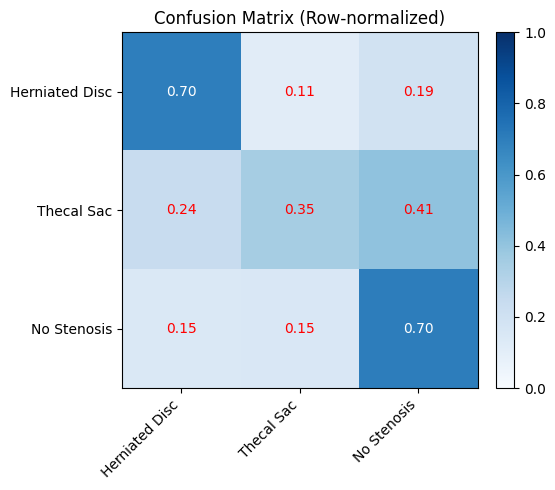

In [5]:
# === Evaluation with Confusion Matrix Heatmap ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# 1) 체크포인트 로드
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

# 2) 예측 함수 (TTA: 원본 + horizontal flip)
@torch.no_grad()
def predict_with_tta(dl):
    ys, ps = [], []
    for imgs, y in dl:
        imgs = imgs.to(device)
        logits = model(imgs)
        logits += model(torch.flip(imgs, dims=[3]))
        preds = (logits / 2.0).argmax(1).cpu().numpy()
        ys.append(np.asarray(y))
        ps.append(preds)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    return ys, ps

# 3) 예측
y_true, y_pred = predict_with_tta(val_dl)

# 4) 성능 지표 출력
acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")
print(f"Validation — Acc: {acc:.4f} | Macro-F1: {f1m:.4f}\n")

print("[Per-class precision / recall / F1 / support]")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=3, zero_division=0))

# 5) 혼동행렬 (히트맵으로)
labels = CLASS_NAMES
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True).clip(min=1)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)

ax.set_title("Confusion Matrix (Row-normalized)")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]:.2f}",
                ha="center", va="center",
                color="red" if cm_norm[i, j] < 0.5 else "white")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
